In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import spacy
import dill






In [2]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load dataset
file_path = 'full_format_recipes.json' 
data = pd.read_json(file_path)
data.dropna(inplace=True)




In [4]:

# Basic exploration
print(f"Dataset shape: {data.shape}")
print("Columns:", data.columns)

Dataset shape: (10608, 11)
Columns: Index(['directions', 'fat', 'date', 'categories', 'calories', 'desc',
       'protein', 'rating', 'title', 'ingredients', 'sodium'],
      dtype='object')


In [5]:
# Focus on relevant columns
StringData = data[['directions', 'desc', 'rating','categories','title']].copy()



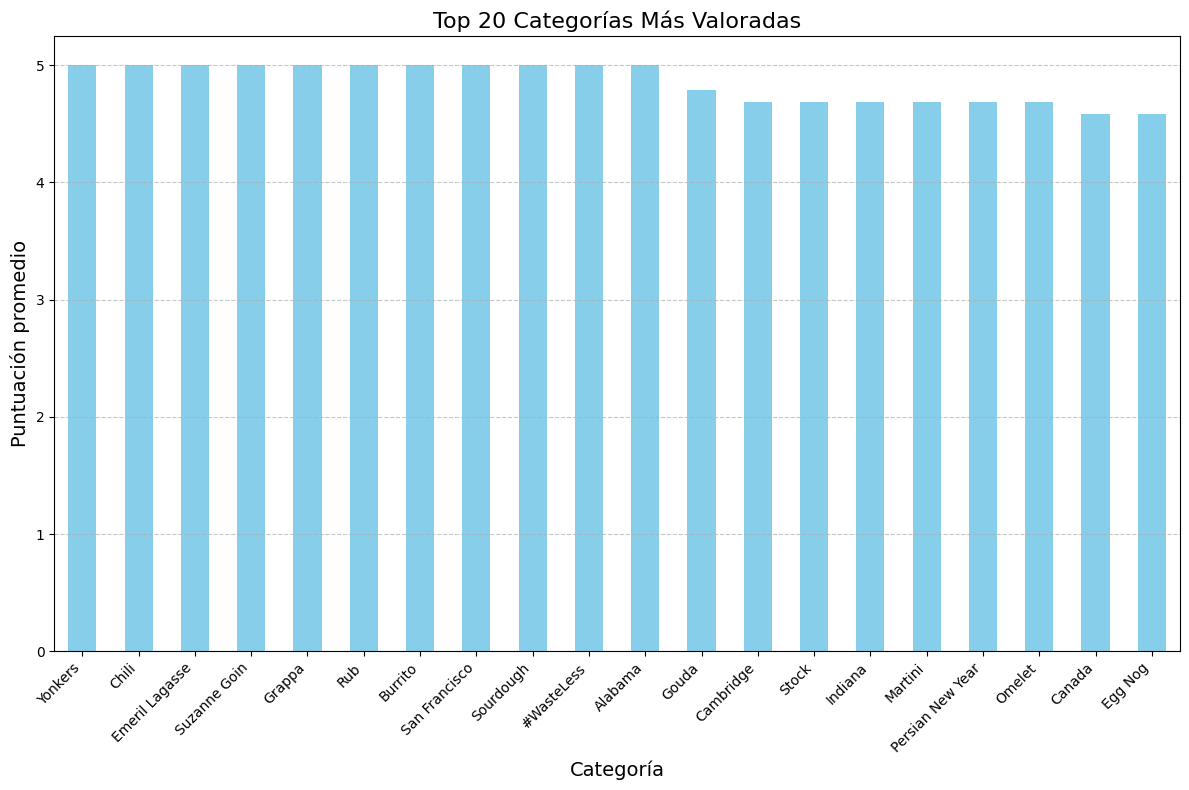

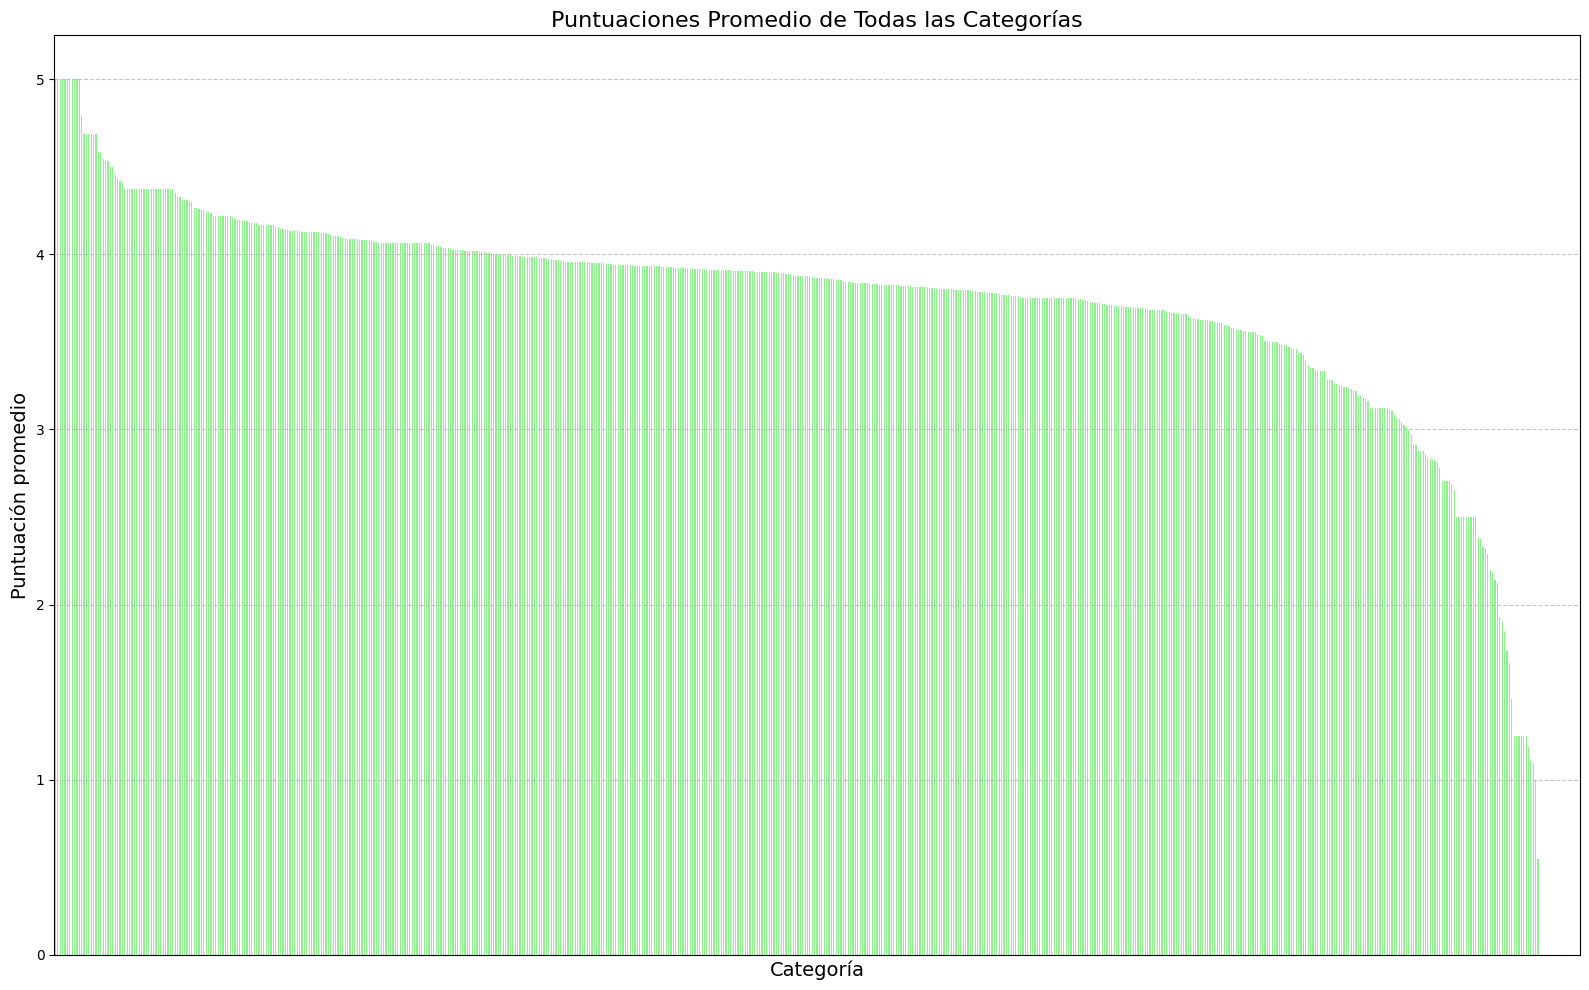

Número total de categorías únicas: 637


In [6]:


# Explode the 'categories' column and calculate mean ratings for each category
categories_exploded = data.explode('categories')
category_ratings = categories_exploded.groupby('categories')['rating'].mean().sort_values(ascending=False)

# Plot the top 20 categories
plt.figure(figsize=(12, 8))
category_ratings.head(20).plot(kind='bar', color='skyblue')
plt.title('Top 20 Categorías Más Valoradas', fontsize=16)
plt.xlabel('Categoría', fontsize=14)
plt.ylabel('Puntuación promedio', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot all categories without x-axis labels
plt.figure(figsize=(16, 10))
category_ratings.plot(kind='bar', color='lightgreen')
plt.title('Puntuaciones Promedio de Todas las Categorías', fontsize=16)
plt.xlabel('Categoría', fontsize=14)
plt.ylabel('Puntuación promedio', fontsize=14)
plt.xticks([])  # Removes x-axis labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display the total number of unique categories
categorias_unicas = categories_exploded['categories'].nunique()
print(f"Número total de categorías únicas: {categorias_unicas}")




In [7]:
# Text preprocessing function
nlp = spacy.load('en_core_web_sm')
def preprocess_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])


In [8]:


# Apply preprocessing
StringData['processed_directions'] = StringData['directions'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))
StringData['processed_desc'] = StringData['desc'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))
StringData['processed_categories'] = StringData['categories'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))
StringData['processed_title'] = StringData['title'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))




In [9]:
print(StringData[['processed_directions', 'processed_desc', 'processed_categories', 'processed_title']].head())

                                 processed_directions  \
1   combine ingredient heavy medium saucepan add s...   
5   Mix basil mayonnaise butter processor basil fi...   
8   stir soy sauce sugar sesame oil white pale gre...   
9   Chop parsley leave measure tablespoon reserve ...   
10  heat oil heavy large skillet medium high heat ...   

                                       processed_desc  \
1   use ingredient find boudin blanc classic frenc...   
5                               recipe prepare minute   
8                                             Bulgogi   
9   transform picnic un pique nique remember elega...   
10        simmer yam fill flavor yield lovely coating   

                                 processed_categories  \
1   Food Processor Onion Pork Bake Bastille Day Ne...   
5   Sandwich Food Processor Tomato kid Friendly Qu...   
8   Beef Ginger Sauté Stir Fry Quick Easy Spring S...   
9   Salad Mustard Potato Picnic Lunch Mayonnaise H...   
10  Milk Cream Dairy Thanksgi

In [10]:
# TF-IDF vectorization for individual columns
vectorizer = TfidfVectorizer(max_features=5000)
categories_tfidf = vectorizer.fit_transform(StringData['processed_categories'])
desc_tfidf = vectorizer.fit_transform(StringData['processed_desc'])
directions_tfidf = vectorizer.fit_transform(StringData['processed_directions'])
title_tfidf = vectorizer.fit_transform(StringData['processed_title'])

In [11]:
# Combine all features into a single DataFrame
numeric_features = data[['fat', 'protein', 'calories', 'sodium']].copy()

scaler = StandardScaler()
numeric_features = scaler.fit_transform(numeric_features)


In [12]:
#Convert data to X and Y
X = torch.tensor(
    pd.concat(
        [pd.DataFrame(categories_tfidf.toarray()), pd.DataFrame(desc_tfidf.toarray()), pd.DataFrame(directions_tfidf.toarray()), pd.DataFrame(title_tfidf.toarray()), pd.DataFrame(numeric_features)],
        axis=1
    ).values,
    dtype=torch.float32
)
y = torch.tensor(data['rating'].values, dtype=torch.float32)  # Target variable



In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [14]:
RF = RandomForestRegressor(n_estimators=100, random_state=42)
RF.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [15]:
# Ensure X_test and y_test are numpy arrays
X_test_np = X_test.cpu().numpy() if isinstance(X_test, torch.Tensor) else X_test
y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test

# Predictions and evaluation
rf_predictions = RF.predict(X_test_np)
print("Random Forest MSE:", mean_squared_error(y_test_np, rf_predictions))
print("Random Forest R2 Score:", r2_score(y_test_np, rf_predictions))


Random Forest MSE: 1.1868865972549483
Random Forest R2 Score: 0.2544667228181239


In [16]:
# Using BERT embeddings for contextual embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

In [17]:
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
    outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().cpu().numpy()


In [18]:

# Generate BERT embeddings for a small subset (for demonstration purposes)##TODO:Don't preprocess
#StringData_reduced100 = StringData[:100]  # Use smaller subset to avoid memory issues
sample_embeddings = np.vstack(StringData['processed_directions'].apply(get_bert_embedding))

RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling cublasLtMatmul with transpose_mat1 1 transpose_mat2 0 m 768 n 88 k 3072 mat1_ld 3072 mat2_ld 3072 result_ld 768 abcType 0 computeType 68 scaleType 0

In [26]:
# Split embeddings
y_sample = StringData['rating']
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    sample_embeddings, y_sample, test_size=0.2, random_state=42)



In [27]:
# Train a neural network using PyTorch
import torch.nn as nn
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(x)

input_size = sample_embeddings.shape[1]
model = SimpleNN(input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
# Convert data to tensors
X_train_tensor = torch.tensor(X_train_bert, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_bert.values, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test_bert, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_bert.values, dtype=torch.float32).view(-1, 1).to(device)

In [ ]:
# Training loop
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")



In [ ]:
# Evaluation

model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())


In [ ]:

dill.dump_session('notebook_env.db')

RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
